## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This is a [fork](https://github.com/mas-dse-greina/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb) of O'Shea, Corgan, and Clancy's Python Notebook.

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Please cite derivative works

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

To run this example, you will need to download or generate the RML2016.10a dataset (https://radioml.com/datasets/)
You will also need Keras installed with either the Theano or Tensor Flow backend working.

Have fun!

In [ ]:
# Standard python imports
# Nothing to see here. Move along.
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, sys
%matplotlib inline

## Keras
[Keras](https://keras.io/) is a python abstraction which allows you to define a neural network and have it automatically coded for deep learning libraries (currently DeepLearning4j, TensorFlow, and Theano). You just tell Keras how many layers are in the network model and define what those layers look like. Keras handles converting it into something that TensorFlow and Theano can use. So it's great for rapid development experimentation with neural networks. You can quickly build things and quickly tweak neural networks.

In [1]:
# Keras imports

# Keras defaults to using TensorFlow.  Nevertheless, we can force it
#    to use whichever deep learning library we wish by specifying
#    the OS variable KERAS_BACKEND.
os.environ["KERAS_BACKEND"] = "theano"
# These THEANO_FLAGS force the use of the GPU. So remove them if you don't have a GPU.
# The code will run several orders of magnitude faster with GPU support.
# Nevertheless, the results are the same regardless of GPU or CPU processing.
# It just depends on how much time you are willing to wait for results.
# Without GPU support, trainining this neural network could take > 5 hours.
# With GPU support, training is reduced to < 30 minutes.
os.environ["THEANO_FLAGS"]  = "floatX=float32,device=gpu,nvcc.flags=-D_FORCE_INLINES"

#os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5110)


# Dataset setup

O'Shea, Corgan, and Clancy generated a simulated data set using [GNU Radio](http://gnuradio.org). It is saved as a Pickle file. That's just a binary file that can be read into Python (it is a dictionary, similar to a JSON file).

There are other data files that you can use to train and test the model at the [radioml.com](https://radioml.com/datasets/radioml-2016-10-dataset/) website.  The Python file to create the dataset is [here](https://github.com/radioML/dataset/blob/master/generate_RML2016.10a.py).

In [2]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
Xd = cPickle.load(open('../RML2016.10a_dict.dat','rb'))

## Pickle format

The data that was saved contained one large Python dictionary array. The dictionary keys were the combinations of [modulation](https://en.wikipedia.org/wiki/Phase-shift_keying) type and signal to noise (SNR) ratios that were simulated by GNU Radio to produce the data. There are 11 modulation schemes: 8 digital and 3 analog. Gaussian white noise was added to each signal proportional to the signal's power.

For example, a [BPSK modulated](https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_.28BPSK.29) signal was simulated with SNRs of -20 dB, -18 dB, -16 dB, up to 18 dB. For a SNR of 0, the BPSK signal would have the same total power as the gaussian noise. For SNRs less than 0, the BPSK signal would be swamped by the noise. In other words, it'd be impossible for a human to identify the modulation for those SNRs.

$$ \text{SNR in decibels} = 10 \times \log \left ( \frac{\text{signal power}}{\text{noise power}} \right ) $$

In [90]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [94]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### Radio frequency (RF) signals

Once we've specified the dictionary key (e.g. ['QAM64', 4] for QAM64 modulation @ 4 dB SNR), then we'll be left with the following matrix.

In [157]:
np.shape(Xd['QAM64', 0])

(1000, 2, 128)

+ The second dimension represents the two components ([I & Q](https://youtu.be/h_7d-m1ehoY)) of the RF signal. 
+ The third dimension represents the 128 samples in time (1 MHz so 1 $\mu$s per index)
+ The first dimension represents the 1,000 sampled windows (each window has the 128 I & Q samples)

$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [197]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 10e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

## Let's plot some of the raw data

So we'll just choose one 8PSK (with SNR @ 18 dB), one PAM4 (with SNR @ 6 dB), one BPSK (with SNR @ 0 dB), and one QAM64 (with SNR @ -12 dB).

Notice how the signal gets buried in the noise as the SNR decreases.

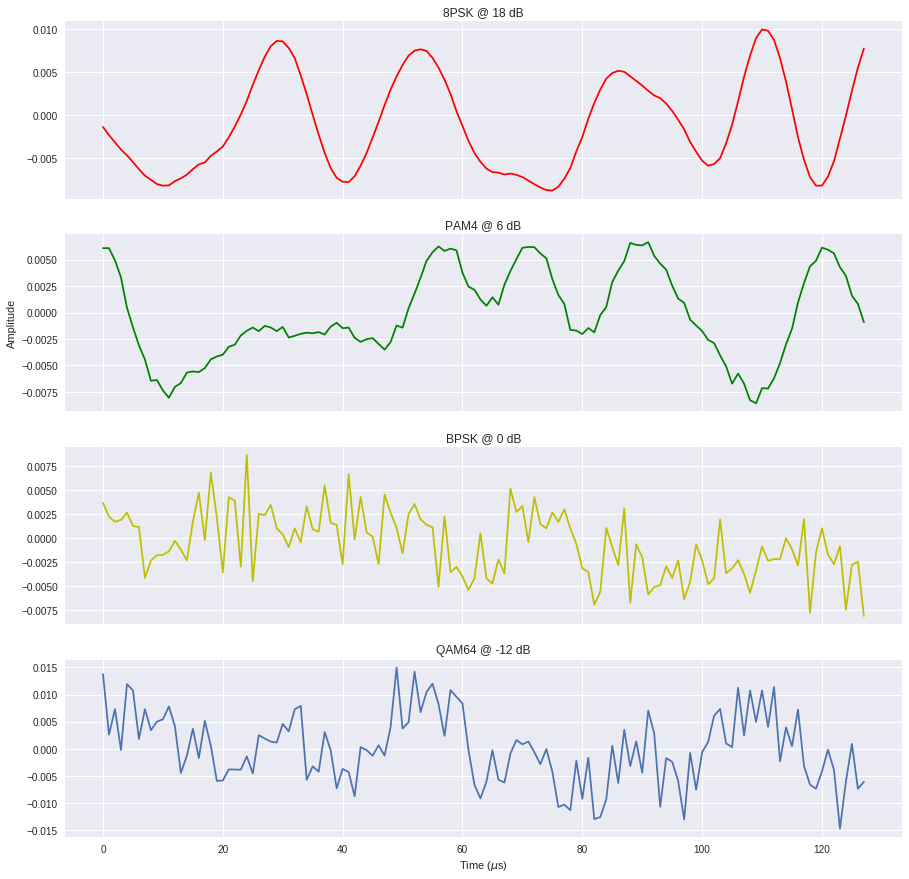

In [199]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

## Now we need to append all of the modulation, SNR, samples, channels, and time points into one big matrix to pass into our neural net

In [192]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [200]:
np.shape(X)

(220000, 2, 128)

### So this is 220,000 sample windows of I/Q channels for 128 time samples

In [205]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)  # Why a 50/50 split instead of 60/40 or 70/30??
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [204]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (110000, 2, 128)
Test set is (110000, 2, 128)


In [206]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print X_train.shape, in_shp
classes = mods

(110000, 2, 128) [2, 128]


# Build the NN Model

In [7]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers

model.add(Reshape(in_shp+[1], input_shape=in_shp))  

model.add(ZeroPadding2D((0, 2)))  # Add 2 columns of zeros to each side
model.add(Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform'))

model.add(Dropout(dr))

model.add(ZeroPadding2D((0, 2))) # Add 2 columns of zeros to each side
model.add(Convolution2D(80, (2, 3), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))

model.add(Dropout(dr))

model.add(Flatten())

model.add(Dense(256, kernel_initializer="he_normal", activation="relu", name="dense1"))

model.add(Dropout(dr))

model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))

model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 2, 134, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 132, 80)        122960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 132, 80)        0         
__________

In [8]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [9]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 110000 samples, validate on 110000 samples
Epoch 1/100
139s - loss: 2.2335 - acc: 0.1539 - val_loss: 2.1088 - val_acc: 0.2013
Epoch 2/100
140s - loss: 2.0115 - acc: 0.2553 - val_loss: 1.8924 - val_acc: 0.2968
Epoch 3/100
139s - loss: 1.8860 - acc: 0.2909 - val_loss: 1.7925 - val_acc: 0.3360
Epoch 4/100
139s - loss: 1.8103 - acc: 0.3278 - val_loss: 1.7094 - val_acc: 0.3731
Epoch 5/100
139s - loss: 1.7372 - acc: 0.3551 - val_loss: 1.6427 - val_acc: 0.3972
Epoch 6/100
139s - loss: 1.6800 - acc: 0.3730 - val_loss: 1.5935 - val_acc: 0.4044
Epoch 7/100
139s - loss: 1.6285 - acc: 0.3915 - val_loss: 1.5209 - val_acc: 0.4370
Epoch 8/100
138s - loss: 1.5884 - acc: 0.4035 - val_loss: 1.4805 - val_acc: 0.4482
Epoch 9/100
139s - loss: 1.5426 - acc: 0.4168 - val_loss: 1.4280 - val_acc: 0.4643
Epoch 10/100
138s - loss: 1.5031 - acc: 0.4294 - val_loss: 1.4158 - val_acc: 0.4656
Epoch 11/100
138s - loss: 1.4783 - acc: 0.4396 - val_loss: 1.3747 - val_acc: 0.4753
Epoch 12/100
138s - loss: 1.4605 

# Evaluate and Plot Model Performance

In [10]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print score

[1.3134182175636291, 0.49388181819482285]


# Plot the model

In [19]:
#!pip install pydot  # Needed for plotting the neural network

  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /home/reina/.cache/pip/wheels/47/8c/c2/4ac7bd0219b4ce5e08d03dc3467014c7a94b2efecfc29df2b2
Successfully built pydot


In [20]:
#!pip install graphviz   # Needed for plotting the neural network

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

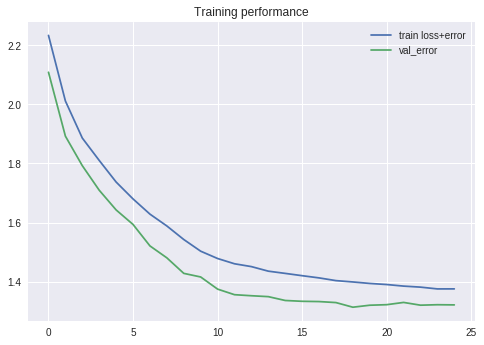

In [13]:
# Show loss curves 
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

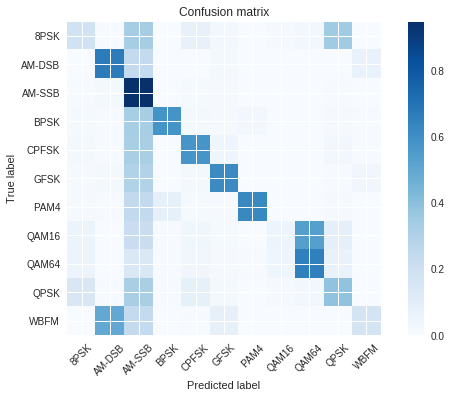

In [15]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.095516925892
Overall Accuracy:  0.0951861943688
Overall Accuracy:  0.0960564399421
Overall Accuracy:  0.102129195236
Overall Accuracy:  0.130173199635
Overall Accuracy:  0.211480362538
Overall Accuracy:  0.313062649274
Overall Accuracy:  0.477272727273
Overall Accuracy:  0.595378927911
Overall Accuracy:  0.657474600871
Overall Accuracy:  0.69799270073
Overall Accuracy:  0.698655034533
Overall Accuracy:  0.718979441997
Overall Accuracy:  0.720397111913
Overall Accuracy:  0.713255184851
Overall Accuracy:  0.725136612022
Overall Accuracy:  0.701249321021
Overall Accuracy:  0.716921941318
Overall Accuracy:  0.707330316742
Overall Accuracy:  0.710711071107


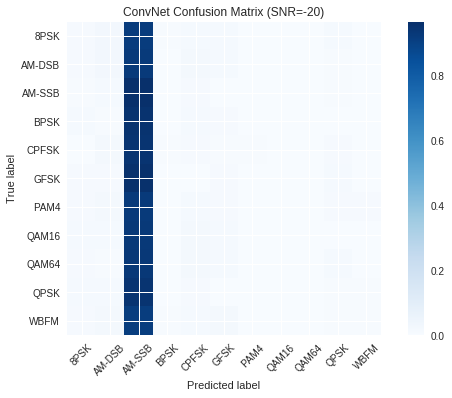

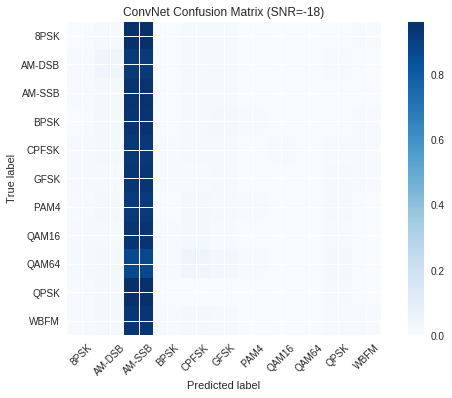

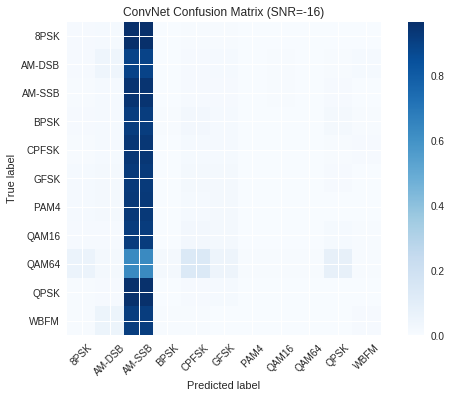

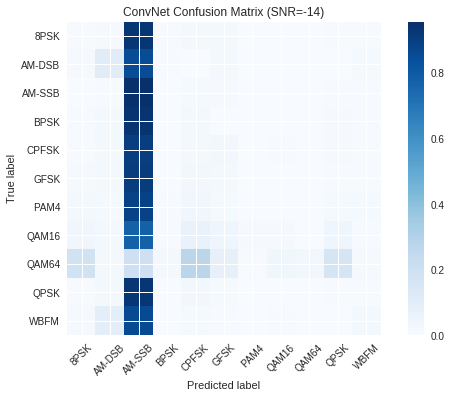

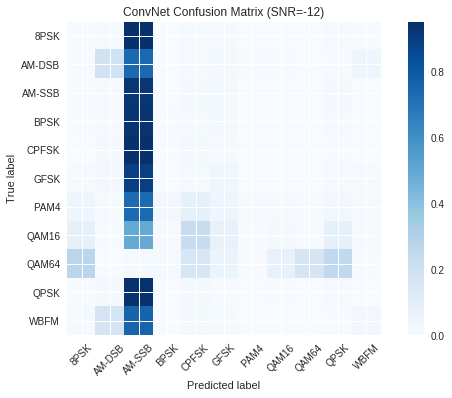

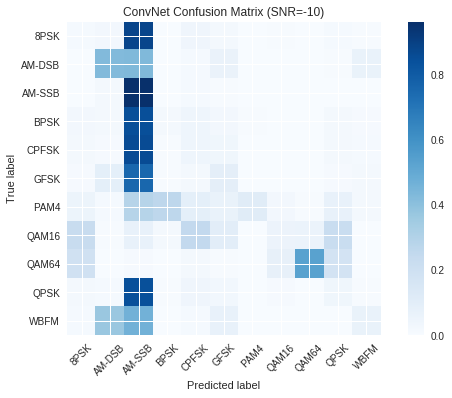

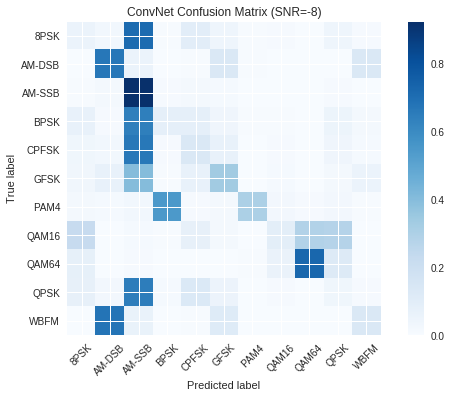

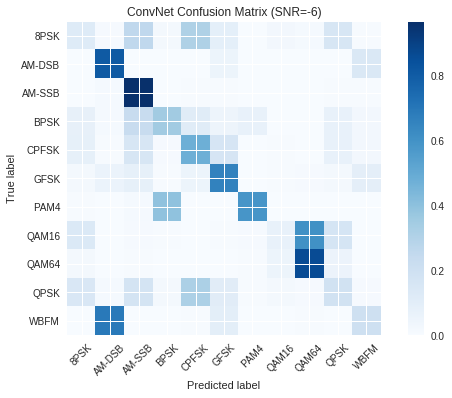

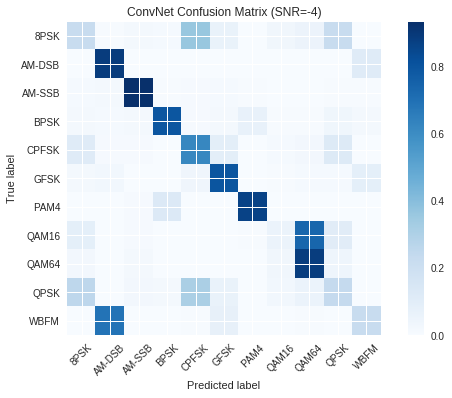

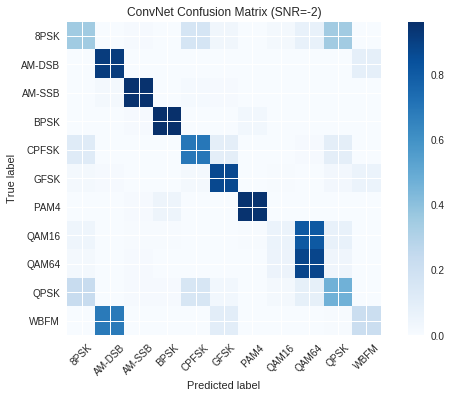

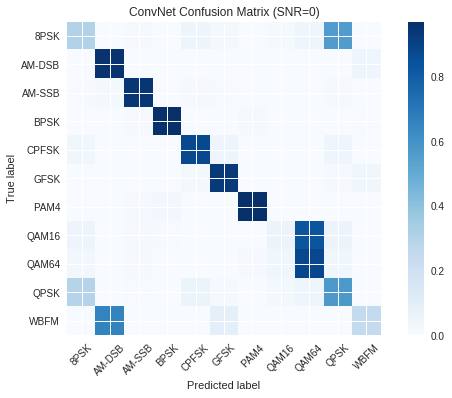

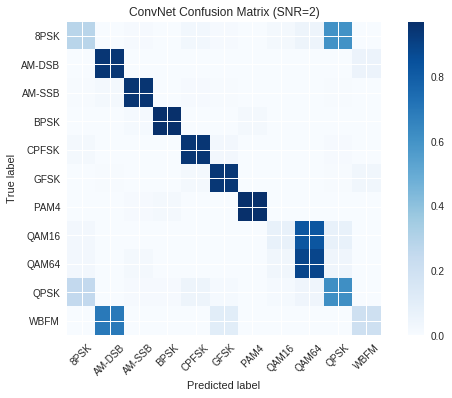

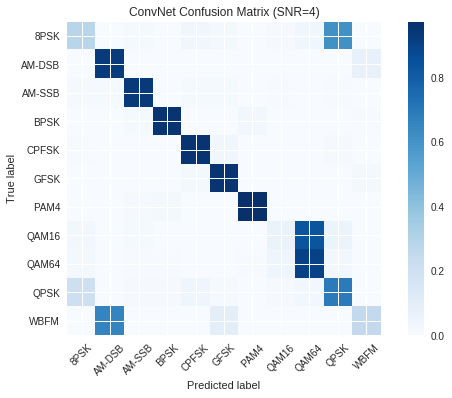

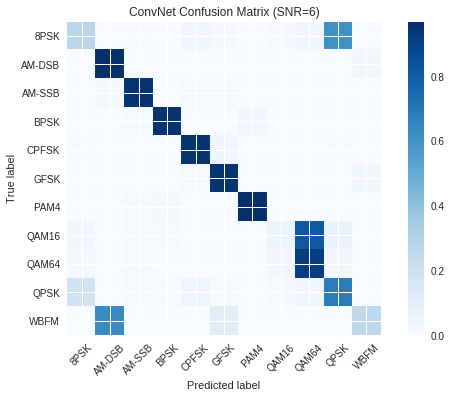

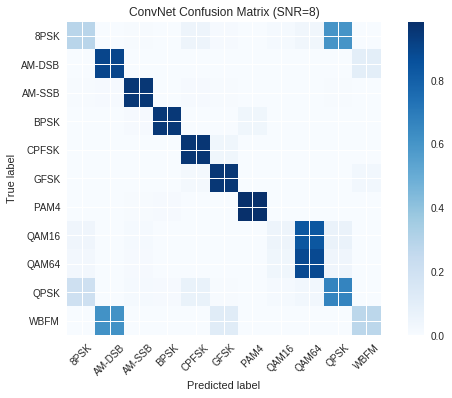

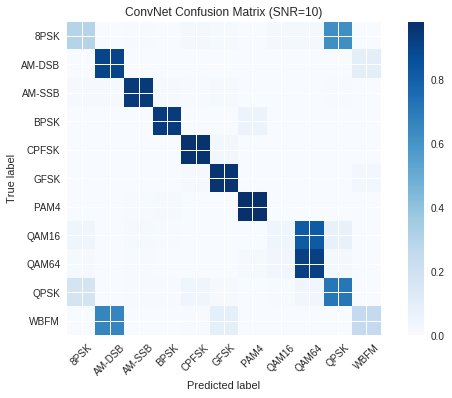

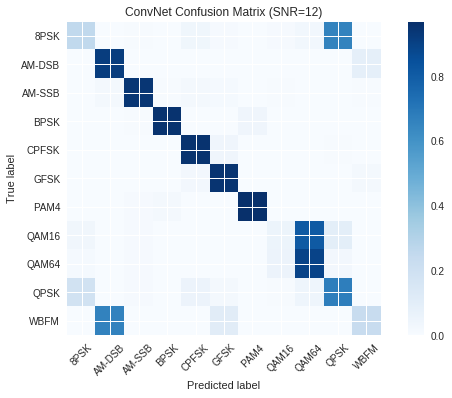

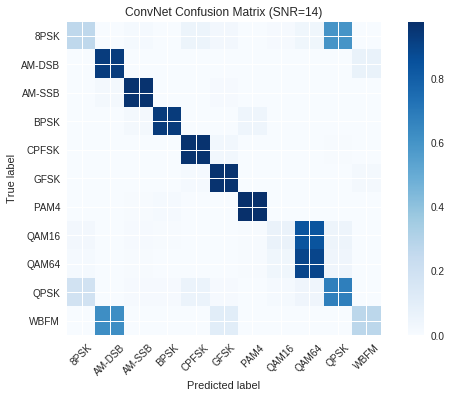

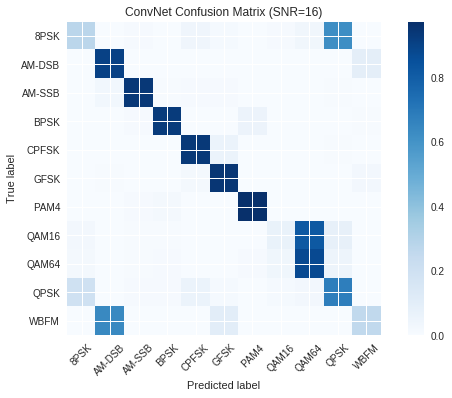

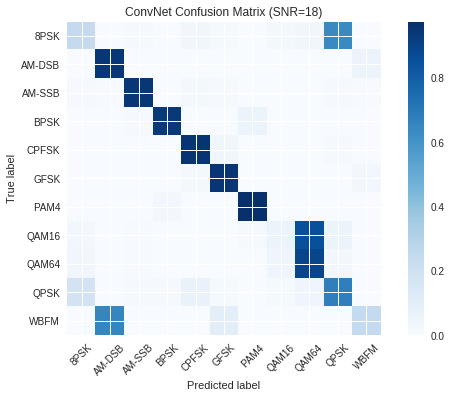

In [16]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [17]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.69799270072992703, 16: 0.70733031674208147, 2: 0.69865503453289712, 4: 0.7189794419970631, 6: 0.72039711191335742, 8: 0.71325518485121731, 12: 0.70124932102118409, 10: 0.72513661202185797, -20: 0.09551692589204025, 18: 0.71071107110711074, -18: 0.095186194368755681, -16: 0.096056439942112881, -14: 0.10212919523637676, -12: 0.13017319963536919, 14: 0.71692194131758624, -10: 0.21148036253776434, -8: 0.31306264927429728, -6: 0.47727272727272729, -4: 0.59537892791127545, -2: 0.65747460087082732}


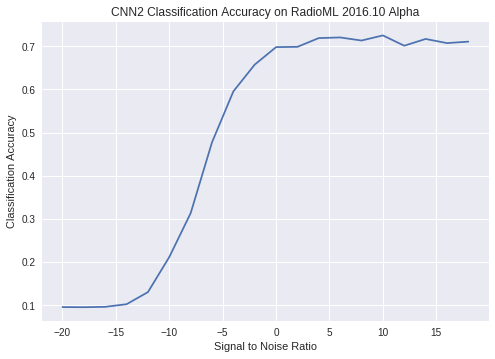

In [18]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");